In [1]:
%reset
#%matplotlib qt

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import mne
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_test
from mne import io
import pickle
from os.path import exists

In [3]:
all_subjects = np.array(
    ['08', '09', '10','11', '12','13', '14', '15', '16','17', '19', '20', '21', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34','35', '36', '37', '38'])
outlier_subs = ['12','14','15','17','27','30','34','36']
valid_subs = np.delete(all_subjects,np.isin(all_subjects,outlier_subs))
subs = valid_subs

subjectWithAllData = '08' # this subjects data will serve as a template for the data df

sfreq=250 ## the maxfreq should be sfreq/2

electrodes = [4,5,10,79,84]
ch_names = ['E6','E7','E13','E106','E112']

epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
prepro_name = "referenced"

In [17]:
example_epochs_filename = "epochs_Wn_s32_file"
data_path = 'C:\AnatArzData\Data\\rerefrenced'
subject_setfile_wake_n = data_path + '\s_32_wake_night_referenced.set'

if exists(example_epochs_filename):
    with open('epochs_Wn_s32_file', 'rb') as config_dictionary_file:
        epochs_Wn_s32_ = pickle.load(config_dictionary_file)
        #print(epochs_Wn_s32_)
else:
    epochs_Wn_s32 = io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,eog=(),verbose=None, uint16_codec=None)
    with open(example_epochs_filename, 'wb') as epochs_Wn_s32_file:
        pickle.dump(epochs_Wn_s32, epochs_Wn_s32_file)

In [5]:
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
epochs_Wn_s32_piked = epochs_Wn_s32.pick_channels(ch_names)
epochs_Wn_s32_monatged = epochs_Wn_s32_piked.set_montage(montage)
info = epochs_Wn_s32_monatged.info

## Import epochs

In [6]:
def getSubEpochsdata(sub_num):
    sub_load_filepath = f'{epochs_dir}\\epochs_sub{sub_num}_{prepro_name}_withElectorodes.mat'
    try:
        matlabImport = scipy.io.loadmat(sub_load_filepath, simplify_cells=True)
    except Exception:
        print(f'Error importing sub file at: {sub_load_filepath}')
        return

    epochs = matlabImport[
        'currSubEpochs']  # dim: vigilStage, elect, T/O/A, height , trialNum, sampleNum_in_cond ,timeSamples
    epochs = np.delete(epochs, 1, axis=0)  # reduce N1
    times = matlabImport['times']
    TOA = matlabImport['TOA']
    toneHieghts = matlabImport['toneHieghts']

    trialnums = matlabImport['trialnums']
    vigilance_states = matlabImport['vigilance_states']
    vigilance_states = np.delete(vigilance_states, 1)  # reduce N1

    electrodes = matlabImport['electrodes'] - 1 # matlab starts counting from 1 and not 0
    sleep_states = matlabImport['sleep_states']
    sleep_states_eeglab = matlabImport['sleep_states_eeglab']
    wake_states = matlabImport['wake_states']
    vigilance_states_eeglab = matlabImport['vigilance_states_eeglab']

    return epochs, vigilance_states, electrodes,TOA, toneHieghts, trialnums, times

epochs, vigilance_states, electrodes, TOA, toneHeights, trialnums, times = getSubEpochsdata(subjectWithAllData)

In [7]:
def getAllSubsEpochsDataAndMeta():
    epochs, vigilance_states, electrodes, TOA, toneHeights, trialnums, times = getSubEpochsdata(subjectWithAllData)

    # get the columns for the conditions table
    numOfRows = len(subs) * len(vigilance_states) * len(toneHeights) * len(TOA) * len(trialnums)
    metadata = np.zeros((numOfRows, 7), dtype=object)

    # populate table and with subject's conditions metadata and create an eeg data dictionary with condition as key
    full_data = {}
    curr_row_num = 0
    for sub_i, sub in enumerate(subs):
        try:
            epochs, vigilance_states, electrodes, TOA, toneHieghts, trialnums, times = getSubEpochsdata(sub)
        except TypeError:
            continue
        for ss_i, ss in enumerate(vigilance_states):
            for toneTy_i, toneTy in enumerate(TOA):
                for toneHi_i, toneHi in enumerate(toneHieghts):
                    for trial_i, trial in enumerate(trialnums):
                        curr_cond_epochs = epochs[ss_i, : ,toneTy_i, toneHi_i, trial_i, :, :]
                        curr_cond_epochs = curr_cond_epochs[~np.all(curr_cond_epochs == 0, axis=2)]  # removes 0 fillers rows
                        curr_cond_epochs=curr_cond_epochs.reshape((np.size(electrodes), -1,np.size(times)))
                        full_data[f"{curr_row_num}"] = curr_cond_epochs
                        sample_in_cond = curr_cond_epochs.shape[1]
                        metadata[curr_row_num, :] = [curr_row_num, sub, ss, toneTy, toneHi, trial, sample_in_cond]

                        curr_row_num += 1

    metadata = metadata[~np.all(metadata == 0, axis=1)]  # removes 0 fillers rows
    full_df = pd.DataFrame(metadata, columns=['Cond_id', 'Subject', 'Vigilance', 'TOA', 'ToneHeight', 'TrialPosition', 'SamplesAmount'])

    return full_data, full_df

full_data, full_df = getAllSubsEpochsDataAndMeta()

In [8]:
## add auxiliary columns

def TOA_type(row):
    if row['TOA'] == 'O' and (row['TrialPosition'] == '6' or row['TrialPosition'] == '7' or row['TrialPosition'] == '8'):
        return 'Rand'
    elif row['TOA'] == 'O' and row['TrialPosition']=='9':
        return 'Fixed'
    else:
        return row['TOA']
full_df['TOA_cond'] = full_df.apply(lambda row: TOA_type(row), axis=1)

In [9]:
full_df

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesAmount,TOA_cond
0,0,08,Wn,T,650,0,24,T
1,1,08,Wn,T,650,1,24,T
2,2,08,Wn,T,650,2,24,T
3,3,08,Wn,T,650,3,24,T
4,4,08,Wn,T,650,4,24,T
...,...,...,...,...,...,...,...,...
22675,22675,38,REM,A,5302,5,0,A
22676,22676,38,REM,A,5302,6,0,A
22677,22677,38,REM,A,5302,7,0,A
22678,22678,38,REM,A,5302,8,0,A


In [10]:
def getAllSampData(df):
    df_minTrials = df[(df.SamplesAmount > 0)] # discard cond with 0 enough samples

    minTrials_cond_keys = np.asarray([str (i) for i in df_minTrials['Cond_id']])
    epochs_allSamples = {}
    evokeds_allSamples = {}

    for key in minTrials_cond_keys:
        epochs_allSamples[key] = full_data[key]
        evokeds_allSamples[key] = np.mean(full_data[key],axis=0)
    return df_minTrials, epochs_allSamples, evokeds_allSamples

In [11]:
# def get_evokedPerCond_ax_mneFunc(ax1,df,condName : str, condVaribles, filterConds, graphColors):
#     evokeds = {}
#     for s,subject in enumerate(subs):
#         evokeds[s] = {}
#         filterConds['Subject'] = subject
#         for val in condVaribles:
#             filterConds[condName] = val
#             curr_subAndCond_electrOverTime = get_avgOverTrials(df, filterConds)
#             curr_subAndCond_electrOverTime /= 1e6
#             evokeds[s][val] = mne.EvokedArray(curr_subAndCond_electrOverTime,info,tmin=-0.1)
#
#     # Edit the data to mne plot format
#     evokeds_mnePlotFormat = {}
#     for val in condVaribles:
#         evokeds_mnePlotFormat[val] = []
#         for sub_i in range(len(subs)):
#             evokeds_mnePlotFormat[val].append(evokeds[sub_i][val])
#
#     plot_compare_evokeds(evokeds_mnePlotFormat,combine = 'mean',colors=graphColors,
#                          axes=ax1,show=False,truncate_xaxis=False, truncate_yaxis=False,
#                          show_sensors = False , legend='upper left')
def applyDesign(ax,title=''):
    ax.set_facecolor('silver')
    ax.set_title(title,fontsize = 18, fontweight = 'bold')
    ax.legend(loc = 'upper right',prop={'size': 10})
    ax.axvline(x=0,color='gray', linestyle='--',label ="_nolegend_")
    ax.axhline(y=0, color='gray', linestyle='-',label ="_nolegend_")
    ax.set_ylabel('magnitude', fontsize = 16, fontweight = 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Frequency (Hz)', fontsize = 16, fontweight = 'bold')

In [25]:
def get_mneEpochs_in_cond(df, conditions):
    curr_df =df.copy()
    for key in conditions:
        curr_df = curr_df[(curr_df[key] == conditions[key])]
    currDf_samps, epochs_samps_per_cond, evokeds_samps = getAllSampData(curr_df)

    epochsArray_in_cond = np.zeros((len(electrodes),len(epochs_samps_per_cond),len(times)))

    for s, samps_in_subcond in enumerate(epochs_samps_per_cond.values()):
        mean_samps_in_subcond = np.mean(samps_in_subcond,axis=1)
        epochsArray_in_cond[:,s,:] = mean_samps_in_subcond

    epochs_arr = np.reshape(epochsArray_in_cond,((len(epochs_samps_per_cond),len(electrodes),len(times))))
    mne_epochs = mne.EpochsArray(1e-6*epochs_arr, info,tmin=-0.1)

    return mne_epochs

## Time-freq functions

In [39]:
n_cycles = 0.5 # trade off between the time vs. freq precision. The more, the better the Freq
p_crit = 0.05
freqs = np.arange(3, 35, 2)  # define frequencies of interest

def time_freq_clustr_perm(conds_1,conds_2,freqs,channel):
    average = channel == 'mean'
    mne_epochs_1 = get_mneEpochs_in_cond(full_df, conds_1)
    mne_epochs_2 = get_mneEpochs_in_cond(full_df, conds_2)

    tfr_epochs_1 = tfr_morlet(mne_epochs_1, freqs,n_cycles=n_cycles,return_itc=False, average=average)
    tfr_epochs_2 = tfr_morlet(mne_epochs_2, freqs,n_cycles=n_cycles, return_itc=False, average=average)
    tfr_epochs_1.apply_baseline(mode='logratio', baseline=(None, 0)) # TODO: mode='ratio'??
    tfr_epochs_2.apply_baseline(mode='logratio', baseline=(None, 0))
    if channel == 'mean':
        epochs_power_1 = tfr_epochs_1.data
        epochs_power_2 = tfr_epochs_2.data
    else:
        epochs_power_1 = tfr_epochs_1.data[:, channel, :, :]
        epochs_power_2 = tfr_epochs_2.data[:, channel, :, :]


    # n_conditions = 2
    # n_observations = epochs_power_1.shape[0] +epochs_power_2.shape[0]
    # dfn = n_conditions - 1  # degrees of freedom numerator
    # dfd = n_observations - n_conditions  # degrees of freedom denominator
    # thresh = scipy.stats.f.ppf(1 - p_crit, dfn=dfn, dfd=dfd)  # F distribution

    threshold = None # The so-called “cluster forming threshold” in the form of a test statistic (note: this is not an alpha level / “p-value”). If None, an F-threshold will be chosen automatically that corresponds to a p-value of 0.05 for the given number of observations (only valid when using an F-statistic).
    F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([epochs_power_1, epochs_power_2], out_type='mask',n_permutations=1000, threshold=threshold, tail=0)
    print(f"F_obs:{F_obs}\nclusters:{clusters}\ncluster_p_values:{cluster_p_values}\nH0:{H0}")

    """plot_timefreq"""
    # fig1, ax1 = plt.subplots(1, 1, figsize=(17, 3))
    # fig2, ax2 = plt.subplots(1, 1, figsize=(12, 3))
    fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
    fig1.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

    # Compute the difference in evoked to determine which was greater since
    # we used a 1-way ANOVA which tested for a difference in population means
    evoked_power_1 = epochs_power_1.mean(axis=0)
    evoked_power_2 = epochs_power_2.mean(axis=0)
    evoked_power_contrast = evoked_power_1 - evoked_power_2
    signs = np.sign(evoked_power_contrast)

    # Create new stats image with only significant clusters
    F_obs_plot = np.nan * np.ones_like(F_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= p_crit: F_obs_plot[c] = F_obs[c] * signs[c]

    ax1.imshow(F_obs, extent=[times[0], times[-1], freqs[0], freqs[-1]],  aspect='auto', origin='lower', cmap='gray')
    max_F = np.nanmax(abs(F_obs_plot))
    im = ax1.imshow(F_obs_plot, extent=[times[0], times[-1], freqs[0], freqs[-1]], aspect='auto', origin='lower', cmap='RdBu_r', vmin=-max_F, vmax=max_F)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_title(f'Induced power - ({ch_names})')
    #fig1.colorbar(im, ax=ax1)

    # plot evoked
    evoked_condition_1 = mne_epochs_1.average()
    evoked_condition_2 = mne_epochs_2.average()
    evoked_contrast = mne.combine_evoked([evoked_condition_1, evoked_condition_2], weights=[1, -1],)
    evoked_contrast.plot(axes=ax2, time_unit='ms')

def time_freq_cond(conds_1,freqs,channel):
    mne_epochs_1 = get_mneEpochs_in_cond(full_df, conds_1)
    mne_epochs_1.plot_psd_topomap(ch_type='eeg', normalize=False)
    power, itc = tfr_morlet(mne_epochs_1, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=1)

    baseline = (times[0], 0)
    power.plot_topo(baseline=baseline, mode='logratio', title='Average power')
    #power.plot([0], baseline=(times[0], 0), mode='logratio', title=ch_names[0])

    fig, axis = plt.subplots(1, 2, figsize=(7, 4))
    power.plot_topomap(ch_type='eeg', tmin=0, tmax=times[-1], fmin=freqs[0], fmax=freqs[-1],
                       baseline=baseline, mode='logratio', axes=axis[0],
                       title='Alpha', show=False)
    power.plot_topomap(ch_type='eeg', tmin=0, tmax=times[-1], fmin=freqs[0], fmax=freqs[-1],
                       baseline=baseline, mode='logratio', axes=axis[1],
                       title='Beta', show=False)
    mne.viz.tight_layout()
    plt.show()

# Resutls

Not setting metadata
1869 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
543 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Using a threshold of 5.317655
stat_fun(H1): min=0.000014 max=5445.549900
Running initial clustering
Found 9 clusters
Permuting 999 times...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_8576\3699246272.py:29: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([epochs_power_1, epochs_power_2], out_type='mask',n_permutations=1000, threshold=threshold, tail=0)


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
F_obs:[[3.73049078e-01 1.93177434e+00 2.68336684e+00 ... 1.19448041e+02
  1.16627821e+02 1.10039179e+02]
 [4.29507877e+01 2.02649895e+01 4.65329721e-03 ... 5.47587420e+01
  7.12760760e+01 5.18491401e+01]
 [8.92777911e+00 3.32575510e+01 2.43347524e+00 ... 5.98055473e+01
  5.96078674e+01 1.70839301e+01]
 ...
 [2.21526935e+01 9.72611187e+00 1.28590528e+00 ... 2.42759850e-02
  9.80286479e-02 2.79915337e-04]
 [2.34253632e+01 8.84007678e+00 1.28838461e+00 ... 2.72666863e-02
  2.79780512e-01 5.33623551e-04]
 [2.44009739e+01 8.22062887e+00 1.32426992e+00 ... 2.54279998e-02
  4.55435108e-01 4.90221132e-03]]
clusters:[array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), a

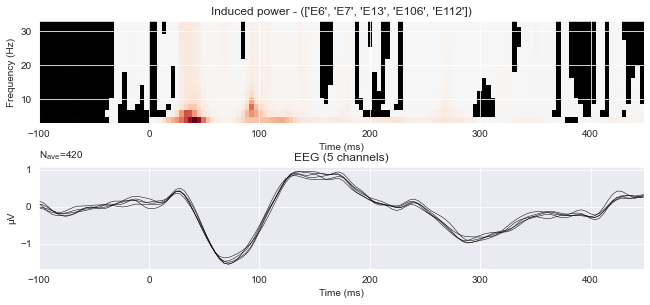

In [40]:
%matplotlib inline
conds_1 = {'TOA_cond':'T','Vigilance':'Wn'}
conds_2 = {'TOA_cond':'Rand','Vigilance':'Wn'}
time_freq_clustr_perm(conds_1,conds_2,freqs,'mean')

In [42]:
%matplotlib qt
conds_1 = {'TOA_cond':'T','Vigilance':'Wn'}
time_freq_cond(conds_1,freqs,'mean')

Not setting metadata
1869 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\Sharon\anaconda3\Lib\site-packages\mne\viz\topomap.py:244: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, format=format)
C:\Users\Sharon\anaconda3\Lib\site-packages\mne\viz\topomap.py:244: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, format=format)
C:\Users\Sharon\anaconda3\Lib\site-packages\mne\viz\topomap.py:244: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, format=format)
C:\Users\Sharon\anaconda3\Lib\site-packages\mne\viz\topomap.py:244: MatplotlibDeprecationWarning: Au

Applying baseline correction (mode: logratio)


C:\Users\Sharon\anaconda3\Lib\site-packages\mne\viz\topo.py:230: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(sm, ax=axes, pad=0.025, fraction=0.075, shrink=0.5,


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


C:\Users\Sharon\anaconda3\Lib\site-packages\mne\viz\topomap.py:244: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, format=format)
C:\Users\Sharon\anaconda3\Lib\site-packages\mne\viz\topomap.py:244: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, format=format)
